This kernel cleans the data and applies various regression algorithms to the processed dataset. The preprocessing is mostly from the following link and I built on this to learn more about the various regression algorithms:

https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset



In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from IPython.display import display
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns



/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Definitions

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline


## Read In Data

The training set has one extra column, the target variable.
In this case this is the SalePrice.  
It also has one extra row.
This second fact isn't significant though.

In [3]:
train = pd.read_csv("data/train.csv")
print("train : " + str(train.shape))

test = pd.read_csv("data/test.csv")
print("test : " + str(test.shape))

train : (1460, 81)
test : (1459, 80)


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Cleaning the data

### Check for Duplicates

In [6]:
# Check for train duplicates
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total train entries")

There are 0 duplicate IDs for 1460 total train entries


In [7]:
# Check for test duplicates
idsUnique = len(set(test.Id))
idsTotal = test.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total test entries")

There are 0 duplicate IDs for 1459 total test entries


### Drop unnecessary columns


In [8]:
train.drop("Id", axis = 1, inplace = True)
test_Id = test["Id"]
test.drop("Id", axis = 1, inplace = True)


### Outliers

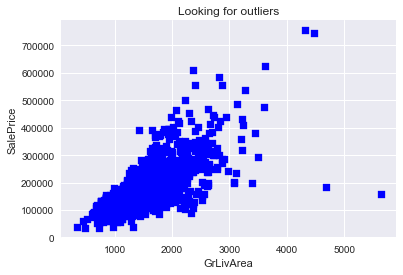

In [9]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

### Analyse the target variable


The SalePrice has a skewed distribution as seen below. The purpose taking the log of it is to obtain residuals that are approximately symmetrically distributed about zero.... Is this true??

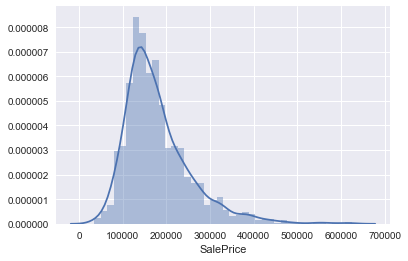

In [10]:
sns.distplot(train['SalePrice']);


In [11]:
# Log transform the target for official scoring
train.SalePrice = np.log(train.SalePrice)
y = train.SalePrice

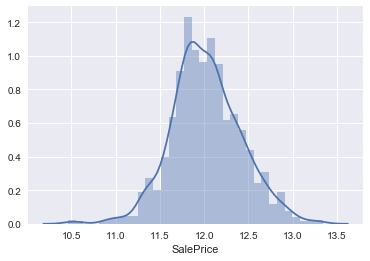

In [12]:
sns.distplot(train['SalePrice']);


### Handle missing values for features where median/mean or most common value doesn't make sense


In [13]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

In [14]:
# Alley : data description says NA means "no alley access"
test.loc[:, "Alley"] = test.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
test.loc[:, "BedroomAbvGr"] = test.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
test.loc[:, "BsmtQual"] = test.loc[:, "BsmtQual"].fillna("No")
test.loc[:, "BsmtCond"] = test.loc[:, "BsmtCond"].fillna("No")
test.loc[:, "BsmtExposure"] = test.loc[:, "BsmtExposure"].fillna("No")
test.loc[:, "BsmtFinType1"] = test.loc[:, "BsmtFinType1"].fillna("No")
test.loc[:, "BsmtFinType2"] = test.loc[:, "BsmtFinType2"].fillna("No")
test.loc[:, "BsmtFullBath"] = test.loc[:, "BsmtFullBath"].fillna(0)
test.loc[:, "BsmtHalfBath"] = test.loc[:, "BsmtHalfBath"].fillna(0)
test.loc[:, "BsmtUnfSF"] = test.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
test.loc[:, "CentralAir"] = test.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
test.loc[:, "Condition1"] = test.loc[:, "Condition1"].fillna("Norm")
test.loc[:, "Condition2"] = test.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
test.loc[:, "EnclosedPorch"] = test.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
test.loc[:, "ExterCond"] = test.loc[:, "ExterCond"].fillna("TA")
test.loc[:, "ExterQual"] = test.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
test.loc[:, "Fence"] = test.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
test.loc[:, "FireplaceQu"] = test.loc[:, "FireplaceQu"].fillna("No")
test.loc[:, "Fireplaces"] = test.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
test.loc[:, "Functional"] = test.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
test.loc[:, "GarageType"] = test.loc[:, "GarageType"].fillna("No")
test.loc[:, "GarageFinish"] = test.loc[:, "GarageFinish"].fillna("No")
test.loc[:, "GarageQual"] = test.loc[:, "GarageQual"].fillna("No")
test.loc[:, "GarageCond"] = test.loc[:, "GarageCond"].fillna("No")
test.loc[:, "GarageArea"] = test.loc[:, "GarageArea"].fillna(0)
test.loc[:, "GarageCars"] = test.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
test.loc[:, "HalfBath"] = test.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
test.loc[:, "HeatingQC"] = test.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
test.loc[:, "KitchenAbvGr"] = test.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
test.loc[:, "KitchenQual"] = test.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
test.loc[:, "LotFrontage"] = test.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
test.loc[:, "LotShape"] = test.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
test.loc[:, "MasVnrType"] = test.loc[:, "MasVnrType"].fillna("None")
test.loc[:, "MasVnrArea"] = test.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
test.loc[:, "MiscFeature"] = test.loc[:, "MiscFeature"].fillna("No")
test.loc[:, "MiscVal"] = test.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
test.loc[:, "OpenPorchSF"] = test.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
test.loc[:, "PavedDrive"] = test.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
test.loc[:, "PoolQC"] = test.loc[:, "PoolQC"].fillna("No")
test.loc[:, "PoolArea"] = test.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
test.loc[:, "SaleCondition"] = test.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
test.loc[:, "ScreenPorch"] = test.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
test.loc[:, "TotRmsAbvGrd"] = test.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
test.loc[:, "Utilities"] = test.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
test.loc[:, "WoodDeckSF"] = test.loc[:, "WoodDeckSF"].fillna(0)

### Some numerical features are actually really categories


In [15]:
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [16]:
test = test.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

### Encode some categorical features as ordered numbers when there is information in the order


In [17]:
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [18]:
# Encode some categorical features as ordered numbers when there is information in the order
test = test.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

### Create Features Part 1: Simplifications of existing features


In [19]:
# Train
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })



In [20]:
# Test
test["SimplOverallQual"] = test.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
test["SimplOverallCond"] = test.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
test["SimplPoolQC"] = test.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
test["SimplGarageCond"] = test.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
test["SimplGarageQual"] = test.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
test["SimplFireplaceQu"] = test.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
test["SimplFireplaceQu"] = test.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
test["SimplFunctional"] = test.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
test["SimplKitchenQual"] = test.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
test["SimplHeatingQC"] = test.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
test["SimplBsmtFinType1"] = test.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
test["SimplBsmtFinType2"] = test.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
test["SimplBsmtCond"] = test.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
test["SimplBsmtQual"] = test.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
test["SimplExterCond"] = test.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
test["SimplExterQual"] = test.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })


### Create Features Part 2: Combinations of existing features


In [21]:
# Train
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [22]:
#Test
# Overall quality of the house
test["OverallGrade"] = test["OverallQual"] * test["OverallCond"]
# Overall quality of the garage
test["GarageGrade"] = test["GarageQual"] * test["GarageCond"]
# Overall quality of the exterior
test["ExterGrade"] = test["ExterQual"] * test["ExterCond"]
# Overall kitchen score
test["KitchenScore"] = test["KitchenAbvGr"] * test["KitchenQual"]
# Overall fireplace score
test["FireplaceScore"] = test["Fireplaces"] * test["FireplaceQu"]
# Overall garage score
test["GarageScore"] = test["GarageArea"] * test["GarageQual"]
# Overall pool score
test["PoolScore"] = test["PoolArea"] * test["PoolQC"]
# Simplified overall quality of the house
test["SimplOverallGrade"] = test["SimplOverallQual"] * test["SimplOverallCond"]
# Simplified overall quality of the exterior
test["SimplExterGrade"] = test["SimplExterQual"] * test["SimplExterCond"]
# Simplified overall pool score
test["SimplPoolScore"] = test["PoolArea"] * test["SimplPoolQC"]
# Simplified overall garage score
test["SimplGarageScore"] = test["GarageArea"] * test["SimplGarageQual"]
# Simplified overall fireplace score
test["SimplFireplaceScore"] = test["Fireplaces"] * test["SimplFireplaceQu"]
# Simplified overall kitchen score
test["SimplKitchenScore"] = test["KitchenAbvGr"] * test["SimplKitchenQual"]
# Total number of bathrooms
test["TotalBath"] = test["BsmtFullBath"] + (0.5 * test["BsmtHalfBath"]) + \
test["FullBath"] + (0.5 * test["HalfBath"])
# Total SF for house (incl. basement)
test["AllSF"] = test["GrLivArea"] + test["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
test["AllFlrsSF"] = test["1stFlrSF"] + test["2ndFlrSF"]
# Total SF for porch
test["AllPorchSF"] = test["OpenPorchSF"] + test["EnclosedPorch"] + \
test["3SsnPorch"] + test["ScreenPorch"]
# Has masonry veneer or not
test["HasMasVnr"] = test.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
test["BoughtOffPlan"] = test.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [23]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SimplPoolScore,SimplGarageScore,SimplFireplaceScore,SimplKitchenScore,TotalBath,AllSF,AllFlrsSF,AllPorchSF,HasMasVnr,BoughtOffPlan
0,SC60,RL,65.000,8450,2,None,4,Lvl,4,Inside,...,0,548,0,2,3.500,2566,1710,61,1,0
1,SC20,RL,80.000,9600,2,None,4,Lvl,4,FR2,...,0,460,1,1,2.500,2524,1262,0,0,0
2,SC60,RL,68.000,11250,2,None,3,Lvl,4,Inside,...,0,608,1,2,3.500,2706,1786,42,1,0
3,SC70,RL,60.000,9550,2,None,3,Lvl,4,Corner,...,0,642,2,2,2.000,2473,1717,307,0,0
4,SC60,RL,84.000,14260,2,None,3,Lvl,4,FR2,...,0,836,1,2,3.500,3343,2198,84,1,0


In [24]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SimplPoolScore,SimplGarageScore,SimplFireplaceScore,SimplKitchenScore,TotalBath,AllSF,AllFlrsSF,AllPorchSF,HasMasVnr,BoughtOffPlan
0,SC20,RH,80.000,11622,2,None,4,Lvl,4,Inside,...,0,730.000,0,1,1.000,1778.000,896,120,0,0
1,SC20,RL,81.000,14267,2,None,3,Lvl,4,Corner,...,0,312.000,0,2,1.500,2658.000,1329,36,1,0
2,SC60,RL,74.000,13830,2,None,3,Lvl,4,Inside,...,0,482.000,1,1,2.500,2557.000,1629,34,0,0
3,SC60,RL,78.000,9978,2,None,3,Lvl,4,Inside,...,0,470.000,2,2,2.500,2530.000,1604,36,1,0
4,SC120,RL,43.000,5005,2,None,3,HLS,4,Inside,...,0,506.000,0,2,2.000,2560.000,1280,226,0,0


### Find most important features relative to target


In [25]:
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice            1.000
OverallQual          0.819
AllSF                0.817
AllFlrsSF            0.729
GrLivArea            0.719
SimplOverallQual     0.708
ExterQual            0.681
GarageCars           0.680
TotalBath            0.673
KitchenQual          0.667
GarageScore          0.657
GarageArea           0.655
TotalBsmtSF          0.642
SimplExterQual       0.636
SimplGarageScore     0.631
BsmtQual             0.615
1stFlrSF             0.614
SimplKitchenQual     0.610
OverallGrade         0.604
SimplBsmtQual        0.594
FullBath             0.591
YearBuilt            0.589
ExterGrade           0.587
YearRemodAdd         0.569
FireplaceQu          0.547
GarageYrBlt          0.544
TotRmsAbvGrd         0.533
SimplOverallGrade    0.527
SimplKitchenScore    0.523
FireplaceScore       0.518
                     ...  
SimplBsmtCond        0.204
BedroomAbvGr         0.204
AllPorchSF           0.199
LotFrontage          0.174
SimplFu

### Create Features Part 3: Polynomials on the top 10 existing features

In [26]:
# Train
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

In [27]:
# Test
test["OverallQual-s2"] = test["OverallQual"] ** 2
test["OverallQual-s3"] = test["OverallQual"] ** 3
test["OverallQual-Sq"] = np.sqrt(test["OverallQual"])
test["AllSF-2"] = test["AllSF"] ** 2
test["AllSF-3"] = test["AllSF"] ** 3
test["AllSF-Sq"] = np.sqrt(test["AllSF"])
test["AllFlrsSF-2"] = test["AllFlrsSF"] ** 2
test["AllFlrsSF-3"] = test["AllFlrsSF"] ** 3
test["AllFlrsSF-Sq"] = np.sqrt(test["AllFlrsSF"])
test["GrLivArea-2"] = test["GrLivArea"] ** 2
test["GrLivArea-3"] = test["GrLivArea"] ** 3
test["GrLivArea-Sq"] = np.sqrt(test["GrLivArea"])
test["SimplOverallQual-s2"] = test["SimplOverallQual"] ** 2
test["SimplOverallQual-s3"] = test["SimplOverallQual"] ** 3
test["SimplOverallQual-Sq"] = np.sqrt(test["SimplOverallQual"])
test["ExterQual-2"] = test["ExterQual"] ** 2
test["ExterQual-3"] = test["ExterQual"] ** 3
test["ExterQual-Sq"] = np.sqrt(test["ExterQual"])
test["GarageCars-2"] = test["GarageCars"] ** 2
test["GarageCars-3"] = test["GarageCars"] ** 3
test["GarageCars-Sq"] = np.sqrt(test["GarageCars"])
test["TotalBath-2"] = test["TotalBath"] ** 2
test["TotalBath-3"] = test["TotalBath"] ** 3
test["TotalBath-Sq"] = np.sqrt(test["TotalBath"])
test["KitchenQual-2"] = test["KitchenQual"] ** 2
test["KitchenQual-3"] = test["KitchenQual"] ** 3
test["KitchenQual-Sq"] = np.sqrt(test["KitchenQual"])
test["GarageScore-2"] = test["GarageScore"] ** 2
test["GarageScore-3"] = test["GarageScore"] ** 3
test["GarageScore-Sq"] = np.sqrt(test["GarageScore"])

In [28]:
train.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
0,SC60,RL,65.000,8450,2,None,4,Lvl,4,Inside,...,1.414,12.250,42.875,1.871,16,64,2.000,2702736,4443297984,40.546
1,SC20,RL,80.000,9600,2,None,4,Lvl,4,FR2,...,1.414,6.250,15.625,1.581,9,27,1.732,1904400,2628072000,37.148
2,SC60,RL,68.000,11250,2,None,3,Lvl,4,Inside,...,1.414,12.250,42.875,1.871,16,64,2.000,3326976,6068404224,42.708
3,SC70,RL,60.000,9550,2,None,3,Lvl,4,Corner,...,1.732,4.000,8.000,1.414,16,64,2.000,3709476,7144450776,43.886
4,SC60,RL,84.000,14260,2,None,3,Lvl,4,FR2,...,1.732,12.250,42.875,1.871,16,64,2.000,6290064,15775480512,50.080


In [29]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
0,SC20,RH,80.000,11622,2,None,4,Lvl,4,Inside,...,1.000,1.000,1.000,1.000,9,27,1.732,4796100.000,10503459000.000,46.797
1,SC20,RL,81.000,14267,2,None,3,Lvl,4,Corner,...,1.000,2.250,3.375,1.225,16,64,2.000,876096.000,820025856.000,30.594
2,SC60,RL,74.000,13830,2,None,3,Lvl,4,Inside,...,1.414,6.250,15.625,1.581,9,27,1.732,2090916.000,3023464536.000,38.026
3,SC60,RL,78.000,9978,2,None,3,Lvl,4,Inside,...,1.414,6.250,15.625,1.581,16,64,2.000,1988100.000,2803221000.000,37.550
4,SC120,RL,43.000,5005,2,None,3,HLS,4,Inside,...,1.414,4.000,8.000,1.414,16,64,2.000,2304324.000,3497963832.000,38.962


### Differentiate numerical features (minus the target) and categorical features


In [30]:
# Train
cat_feat_train = train.select_dtypes(include = ["object"]).columns
num_feat_train = train.select_dtypes(exclude = ["object"]).columns
num_feat_train = num_feat_train.drop("SalePrice")
print("Numerical features : " + str(len(num_feat_train)))
print("Categorical features : " + str(len(cat_feat_train)))
train_num = train[num_feat_train]
train_cat = train[cat_feat_train]

Numerical features : 117
Categorical features : 26


In [31]:
# Test
cat_feat_test = test.select_dtypes(include = ["object"]).columns
num_feat_test = test.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(num_feat_test)))
print("Categorical features : " + str(len(cat_feat_test)))
test_num = test[num_feat_test]
test_cat = test[cat_feat_test]

Numerical features : 117
Categorical features : 26


### Handle remaining missing values for numerical features by using median as replacement


In [32]:
# Train
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


In [33]:
# Test
print("NAs for numerical features in test : " + str(test_num.isnull().values.sum()))
test_num = test_num.fillna(test_num.median())
print("Remaining NAs for numerical features in test : " + str(test_num.isnull().values.sum()))

NAs for numerical features in test : 85
Remaining NAs for numerical features in test : 0


In [34]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
0,SC60,RL,65.000,8450,2,None,4,Lvl,4,Inside,...,1.414,12.250,42.875,1.871,16,64,2.000,2702736,4443297984,40.546
1,SC20,RL,80.000,9600,2,None,4,Lvl,4,FR2,...,1.414,6.250,15.625,1.581,9,27,1.732,1904400,2628072000,37.148
2,SC60,RL,68.000,11250,2,None,3,Lvl,4,Inside,...,1.414,12.250,42.875,1.871,16,64,2.000,3326976,6068404224,42.708
3,SC70,RL,60.000,9550,2,None,3,Lvl,4,Corner,...,1.732,4.000,8.000,1.414,16,64,2.000,3709476,7144450776,43.886
4,SC60,RL,84.000,14260,2,None,3,Lvl,4,FR2,...,1.732,12.250,42.875,1.871,16,64,2.000,6290064,15775480512,50.080


In [35]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
0,SC20,RH,80.000,11622,2,None,4,Lvl,4,Inside,...,1.000,1.000,1.000,1.000,9,27,1.732,4796100.000,10503459000.000,46.797
1,SC20,RL,81.000,14267,2,None,3,Lvl,4,Corner,...,1.000,2.250,3.375,1.225,16,64,2.000,876096.000,820025856.000,30.594
2,SC60,RL,74.000,13830,2,None,3,Lvl,4,Inside,...,1.414,6.250,15.625,1.581,9,27,1.732,2090916.000,3023464536.000,38.026
3,SC60,RL,78.000,9978,2,None,3,Lvl,4,Inside,...,1.414,6.250,15.625,1.581,16,64,2.000,1988100.000,2803221000.000,37.550
4,SC120,RL,43.000,5005,2,None,3,HLS,4,Inside,...,1.414,4.000,8.000,1.414,16,64,2.000,2304324.000,3497963832.000,38.962


### Create dummy features for categorical values via one-hot encoding

In [36]:
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


In [37]:
print("NAs for categorical features in test : " + str(test_cat.isnull().values.sum()))
test_cat = pd.get_dummies(test_cat)
print("Remaining NAs for categorical features in test : " + str(test_cat.isnull().values.sum()))

NAs for categorical features in test : 7
Remaining NAs for categorical features in test : 0


In [38]:
print("New number of train cat features : " + str(train_cat.shape[1]))
print("New number of train num features : " + str(train_num.shape[1]))
print("New number of test cat features : " + str(test_cat.shape[1]))
print("New number of test num features : " + str(test_num.shape[1]))

New number of train cat features : 202
New number of train num features : 117
New number of test cat features : 189
New number of test num features : 117


### Join categorical and numerical features


In [39]:
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))

New number of features : 319


In [40]:
test = pd.concat([test_num, test_cat], axis = 1)
print("New number of features : " + str(test.shape[1]))


New number of features : 306


In [41]:
train.head()


,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.000,8450,2,4,4,3,7,5,2003,2003,...,0,0,0,1,0,0,0,0,1,0
1,80.000,9600,2,4,4,3,6,8,1976,1976,...,0,0,0,1,0,0,0,0,1,0
2,68.000,11250,2,3,4,3,7,5,2001,2002,...,0,0,0,1,0,0,0,0,1,0
3,60.000,9550,2,3,4,3,7,5,1915,1970,...,0,0,0,1,1,0,0,0,0,0
4,84.000,14260,2,3,4,3,8,5,2000,2000,...,0,0,0,1,0,0,0,0,1,0


In [42]:
test.head()


,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,80.000,11622,2,4,4,3,5,6,1961,1961,...,0,0,0,1,0,0,0,0,1,0
1,81.000,14267,2,3,4,3,6,6,1958,1958,...,0,0,0,1,0,0,0,0,1,0
2,74.000,13830,2,3,4,3,5,5,1997,1998,...,0,0,0,1,0,0,0,0,1,0
3,78.000,9978,2,3,4,3,6,6,1998,1998,...,0,0,0,1,0,0,0,0,1,0
4,43.000,5005,2,3,4,3,8,5,1992,1992,...,0,0,0,1,0,0,0,0,1,0


### Drop columns which are in the training set but not in the test set and vice versa


In [43]:
extra_cols = list(set(train.columns.tolist()) - set(test.columns.tolist()))
extra_cols

['HouseStyle_2.5Fin',
 'Exterior1st_ImStucc',
 'Exterior2nd_Other',
 'RoofMatl_Membran',
 'MiscFeature_TenC',
 'Condition2_RRAe',
 'Heating_Floor',
 'Condition2_RRNn',
 'RoofMatl_Metal',
 'Exterior1st_Stone',
 'RoofMatl_Roll',
 'Electrical_Mix',
 'Condition2_RRAn',
 'Heating_OthW']

In [44]:
train = train.drop(extra_cols, 1)

In [45]:
extra_cols = list(set(test.columns.tolist()) - set(train.columns.tolist()))
extra_cols

['MSSubClass_SC150']

In [46]:
# Drop columns which are in the test set but not in the train set
test = test.drop(extra_cols, 1)

In [47]:
print(train.shape)

(1456, 305)


In [48]:
print(y.shape)

(1456,)


## Split the dataset into train + validation sets


In [49]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))
print("test : " + str(test.shape))

X_train : (1019, 305)
X_test : (437, 305)
y_train : (1019,)
y_test : (437,)
test : (1459, 305)


In [50]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, num_feat_train] = stdSc.fit_transform(X_train.loc[:, num_feat_train])
X_test.loc[:, num_feat_train] = stdSc.transform(X_test.loc[:, num_feat_train])
test.loc[:, num_feat_test] = stdSc.transform(test.loc[:, num_feat_test])


/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [51]:
X_train.head()

,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
328,-1.720,0.144,0.063,-1.039,0.031,0.235,-0.058,0.409,-1.767,0.436,...,0,0,0,1,0,0,0,0,1,0
1026,0.467,-0.122,0.063,0.708,0.031,0.235,-0.794,-0.489,-0.347,-1.221,...,0,0,0,1,0,0,0,0,1,0
843,0.677,-0.256,0.063,0.708,0.031,0.235,-0.794,-1.387,-0.315,-1.173,...,0,0,0,1,0,0,0,0,1,0
994,1.156,0.203,0.063,0.708,0.031,0.235,2.886,-0.489,1.137,1.070,...,0,0,0,1,0,0,0,0,1,0
1226,0.856,0.423,0.063,-1.039,0.031,0.235,-0.058,-0.489,1.170,1.070,...,0,0,0,1,0,0,0,0,1,0


In [52]:
test.head()

,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.677,0.117,0.063,0.708,0.031,0.235,-0.794,0.409,-0.315,-1.173,...,0,0,0,1,0,0,0,0,1,0
1,0.706,0.389,0.063,-1.039,0.031,0.235,-0.058,0.409,-0.412,-1.319,...,0,0,0,1,0,0,0,0,1,0
2,0.497,0.344,0.063,-1.039,0.031,0.235,-0.794,-0.489,0.847,0.631,...,0,0,0,1,0,0,0,0,1,0
3,0.617,-0.052,0.063,-1.039,0.031,0.235,-0.058,0.409,0.879,0.631,...,0,0,0,1,0,0,0,0,1,0
4,-0.432,-0.564,0.063,-1.039,0.031,0.235,1.414,-0.489,0.685,0.339,...,0,0,0,1,0,0,0,0,1,0


### Error Metric

In [53]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv(model, data, labels):
    rmse= np.sqrt(-cross_val_score(model, data, labels, scoring = scorer, cv = 10))
    return(rmse)


### Models

### 1) Linear Regression 

In [54]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [55]:
# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv(lr, X_train, y_train).mean())
print("RMSE on Test set :", rmse_cv(lr, X_test, y_test).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
linear_test_pred = lr.predict(test)


RMSE on Training set : 11632218551.2
RMSE on Test set : 0.856094851072


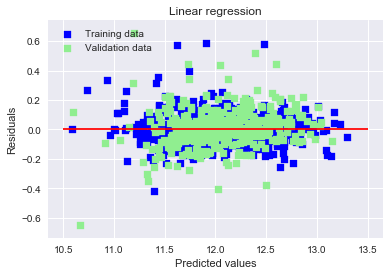

In [56]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()


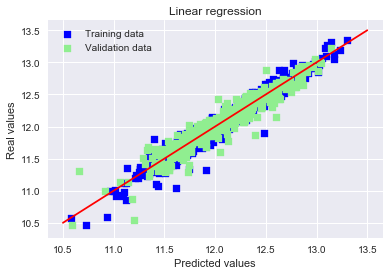

In [57]:
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

### 2) Ridge Regression


In [58]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv(ridge, X_train, y_train).mean())
print("Ridge RMSE on Test set :", rmse_cv(ridge, X_test, y_test).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)
ridge_test_pred = ridge.predict(test)


Best alpha : 30.0
Try again for more precision with alphas centered around 30.0
Best alpha : 39.0
Ridge RMSE on Training set : 0.11566086204
Ridge RMSE on Test set : 0.119420769565


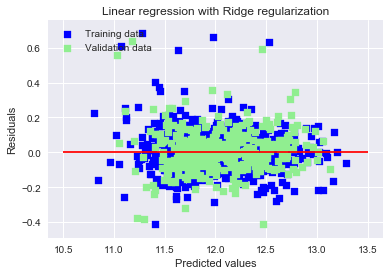

In [59]:
# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

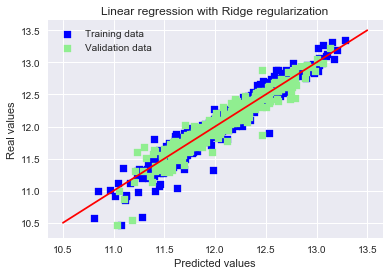

In [60]:
# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Ridge picked 305 features and eliminated the other 0 features


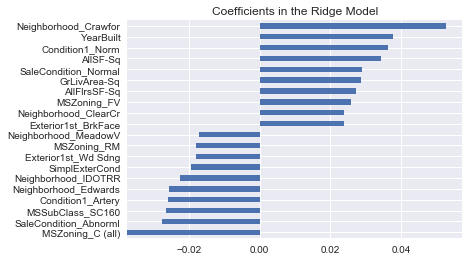

In [61]:
# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

### 3) Linear Regression with Lasso regularization (L1 penalty)



In [62]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv(lasso, X_train, y_train).mean())
print("Lasso RMSE on Test set :", rmse_cv(lasso, X_test, y_test).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)
lasso_test_pred = lasso.predict(test)


Best alpha : 0.0006
Try again for more precision with alphas centered around 0.0006
Best alpha : 0.00054
Lasso RMSE on Training set : 0.112806784399
Lasso RMSE on Test set : 0.118604830078


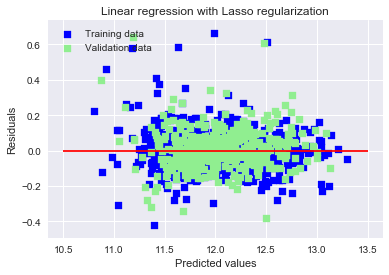

In [63]:
# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

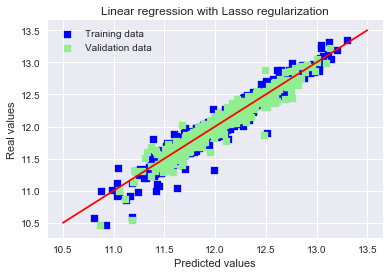

In [64]:
# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Lasso picked 122 features and eliminated the other 183 features


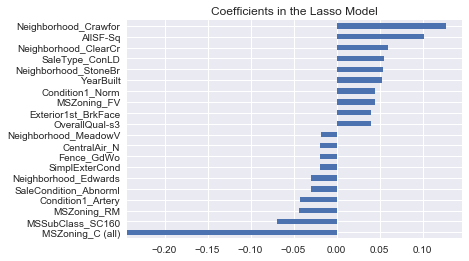

In [65]:
# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

### 4) ElasticNet


In [66]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best l1_ratio : 0.95
Best alpha : 0.0006


In [67]:
print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )


Try again for more precision with l1_ratio centered around 0.95
Best l1_ratio : 0.95
Best alpha : 0.0006


In [68]:
print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Now try again for more precision on alpha, with l1_ratio fixed at 0.95 and alpha centered around 0.0006
Best l1_ratio : 0.95
Best alpha : 0.00057


In [69]:
print("ElasticNet RMSE on Training set :", rmse_cv(elasticNet, X_train, y_train).mean())
print("ElasticNet RMSE on Test set :", rmse_cv(elasticNet, X_test, y_test).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)
elasticNet_test_pred = elasticNet.predict(test)


ElasticNet RMSE on Training set : 0.112878717333
ElasticNet RMSE on Test set : 0.118693682584


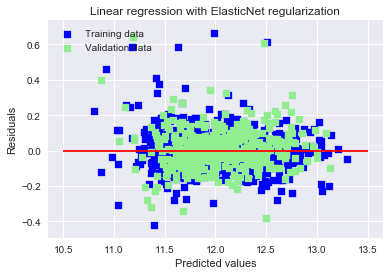

In [70]:
# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

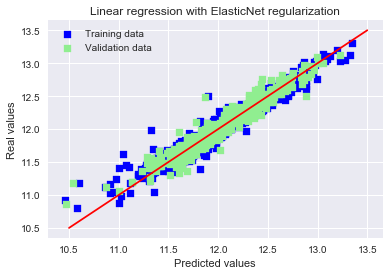

In [71]:
# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

ElasticNet picked 122 features and eliminated the other 183 features


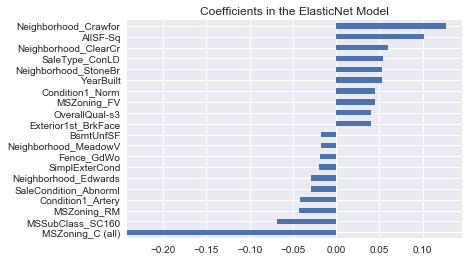

In [72]:
# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

### 5) XGBoost

Parameters:  
colsample_bytree: Denotes the fraction of columns to be randomly samples for each tree (0.5 -> 1)  

Gamma: A node is split only when the resulting split gives a positive reduction in the loss function.  
Gamma specifies the minimum loss reduction required to make a split.  
Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.  

max_depth: The maximum depth of a tree, same as GBM.  
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular   sample. Should be tuned using CV.  
Typical values: 3-10  

silent: Whether or not to print messages


#### Parameter Tuning:

High level parameter search

In [76]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

In [77]:
gsearch1 = GridSearchCV(
    estimator = xgb.XGBRegressor( 
        colsample_bytree=0.2,
        gamma=0.0,
        learning_rate=0.01,
        max_depth=4,
        min_child_weight=1.5,
        n_estimators=7200,                                                                  
        reg_alpha=0.9,
        reg_lambda=0.6,
        subsample=0.2,
        seed=42,
        silent=0),                        
    param_grid = param_test1, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5
)



In [78]:
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7fbfeb4b2f60, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/phil/anaconda2/envs/p35/lib/python3.5/site...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/phil/a.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fbfeb4b2f60, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/phil/anaconda2/envs/p35/lib/python3.5/site...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/phil/a.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'gsearch1.fit(X_train, y_train)\ngsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-10-29T10:17:28.227015', 'msg_id': '43B219B0D26242489AA70E13B9D58226', 'msg_type': 'execute_request', 'session': '7BEA3922CCCC40B28B692986FBEDDE59', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '43B219B0D26242489AA70E13B9D58226', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'7BEA3922CCCC40B28B692986FBEDDE59']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'gsearch1.fit(X_train, y_train)\ngsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-10-29T10:17:28.227015', 'msg_id': '43B219B0D26242489AA70E13B9D58226', 'msg_type': 'execute_request', 'session': '7BEA3922CCCC40B28B692986FBEDDE59', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '43B219B0D26242489AA70E13B9D58226', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'7BEA3922CCCC40B28B692986FBEDDE59'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'gsearch1.fit(X_train, y_train)\ngsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-10-29T10:17:28.227015', 'msg_id': '43B219B0D26242489AA70E13B9D58226', 'msg_type': 'execute_request', 'session': '7BEA3922CCCC40B28B692986FBEDDE59', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '43B219B0D26242489AA70E13B9D58226', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='gsearch1.fit(X_train, y_train)\ngsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'gsearch1.fit(X_train, y_train)\ngsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('gsearch1.fit(X_train, y_train)\ngsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('gsearch1.fit(X_train, y_train)\ngsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='gsearch1.fit(X_train, y_train)\ngsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-78-8e17bc0800de>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fbfa639e3c8, executi..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fbfa6772ed0, file "<ipython-input-78-8e17bc0800de>", line 1>
        result = <ExecutionResult object at 7fbfa639e3c8, executi..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fbfa6772ed0, file "<ipython-input-78-8e17bc0800de>", line 1>, result=<ExecutionResult object at 7fbfa639e3c8, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fbfa6772ed0, file "<ipython-input-78-8e17bc0800de>", line 1>
        self.user_global_ns = {'ElasticNetCV': <class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# Imports\nimport pandas as pd\nimport numpy as np...s plt\nimport xgboost as xgb\nimport seaborn as sns', "pd.set_option('display.float_format', lambda x: '%.3f' % x)\nget_ipython().magic('matplotlib inline')", 'train = pd.read_csv("data/train.csv")\nprint("tra...ata/test.csv")\nprint("test : " + str(test.shape))', 'train.head()', 'test.head()', '# Check for train duplicates\nidsUnique = len(set...s for " + str(idsTotal) + " total train entries")', '# Check for test duplicates\nidsUnique = len(set(...Ds for " + str(idsTotal) + " total test entries")', 'train.drop("Id", axis = 1, inplace = True)\ntest_...t["Id"]\ntest.drop("Id", axis = 1, inplace = True)', '# Looking for outliers, as indicated in https://...plt.show()\n\ntrain = train[train.GrLivArea < 4000]', "sns.distplot(train['SalePrice']);", '# Log transform the target for official scoring\n...ice = np.log(train.SalePrice)\ny = train.SalePrice', "sns.distplot(train['SalePrice']);", '# Handle missing values for features where media...odDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)', '# Alley : data description says NA means "no all...oodDeckSF"] = test.loc[:, "WoodDeckSF"].fillna(0)', 'train = train.replace({"MSSubClass" : {20 : "SC2... 11 : "Nov", 12 : "Dec"}\n                      })', 'test = test.replace({"MSSubClass" : {20 : "SC20"... 11 : "Nov", 12 : "Dec"}\n                      })', 'train = train.replace({"Alley" : {"Grvl" : 1, "P...oSewr" : 3, "AllPub" : 4}}\n                     )', '# Encode some categorical features as ordered nu...oSewr" : 3, "AllPub" : 4}}\n                     )', '# Train\ntrain["SimplOverallQual"] = train.Overal...                                               })', ...], 'LassoCV': <class 'sklearn.linear_model.coordinate_descent.LassoCV'>, 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {4:    Id  MSSubClass MSZoning  LotFrontage  LotArea...       Normal     250000  

[5 rows x 81 columns], 5:      Id  MSSubClass MSZoning  LotFrontage  LotAr...       WD         Normal  

[5 rows x 80 columns], 23:   MSSubClass MSZoning  LotFrontage  LotArea  Str...       1              0  

[5 rows x 114 columns], 24:   MSSubClass MSZoning  LotFrontage  LotArea  Str...       0              0  

[5 rows x 113 columns], 28:   MSSubClass MSZoning  LotFrontage  LotArea  Str...5480512          50.080  

[5 rows x 144 columns], 29:   MSSubClass MSZoning  LotFrontage  LotArea  Str...832.000          38.962  

[5 rows x 143 columns], 34:   MSSubClass MSZoning  LotFrontage  LotArea  Str...5480512          50.080  

[5 rows x 144 columns], 35:   MSSubClass MSZoning  LotFrontage  LotArea  Str...832.000          38.962  

[5 rows x 143 columns], 41:    LotFrontage  LotArea  Street  LotShape  Utili...                      0  

[5 rows x 319 columns], 42:    LotFrontage  LotArea  Street  LotShape  Utili...                      0  

[5 rows x 306 columns], ...}, 'RidgeCV': <class 'sklearn.linear_model.ridge.RidgeCV'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'X_test':       LotFrontage  LotArea  Street  LotShape  Ut...                    0  

[437 rows x 305 columns], 'X_train':       LotFrontage  LotArea  Street  LotShape  Ut...                   0  

[1019 rows x 305 columns], ...}
        self.user_ns = {'ElasticNetCV': <class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# Imports\nimport pandas as pd\nimport numpy as np...s plt\nimport xgboost as xgb\nimport seaborn as sns', "pd.set_option('display.float_format', lambda x: '%.3f' % x)\nget_ipython().magic('matplotlib inline')", 'train = pd.read_csv("data/train.csv")\nprint("tra...ata/test.csv")\nprint("test : " + str(test.shape))', 'train.head()', 'test.head()', '# Check for train duplicates\nidsUnique = len(set...s for " + str(idsTotal) + " total train entries")', '# Check for test duplicates\nidsUnique = len(set(...Ds for " + str(idsTotal) + " total test entries")', 'train.drop("Id", axis = 1, inplace = True)\ntest_...t["Id"]\ntest.drop("Id", axis = 1, inplace = True)', '# Looking for outliers, as indicated in https://...plt.show()\n\ntrain = train[train.GrLivArea < 4000]', "sns.distplot(train['SalePrice']);", '# Log transform the target for official scoring\n...ice = np.log(train.SalePrice)\ny = train.SalePrice', "sns.distplot(train['SalePrice']);", '# Handle missing values for features where media...odDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)', '# Alley : data description says NA means "no all...oodDeckSF"] = test.loc[:, "WoodDeckSF"].fillna(0)', 'train = train.replace({"MSSubClass" : {20 : "SC2... 11 : "Nov", 12 : "Dec"}\n                      })', 'test = test.replace({"MSSubClass" : {20 : "SC20"... 11 : "Nov", 12 : "Dec"}\n                      })', 'train = train.replace({"Alley" : {"Grvl" : 1, "P...oSewr" : 3, "AllPub" : 4}}\n                     )', '# Encode some categorical features as ordered nu...oSewr" : 3, "AllPub" : 4}}\n                     )', '# Train\ntrain["SimplOverallQual"] = train.Overal...                                               })', ...], 'LassoCV': <class 'sklearn.linear_model.coordinate_descent.LassoCV'>, 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {4:    Id  MSSubClass MSZoning  LotFrontage  LotArea...       Normal     250000  

[5 rows x 81 columns], 5:      Id  MSSubClass MSZoning  LotFrontage  LotAr...       WD         Normal  

[5 rows x 80 columns], 23:   MSSubClass MSZoning  LotFrontage  LotArea  Str...       1              0  

[5 rows x 114 columns], 24:   MSSubClass MSZoning  LotFrontage  LotArea  Str...       0              0  

[5 rows x 113 columns], 28:   MSSubClass MSZoning  LotFrontage  LotArea  Str...5480512          50.080  

[5 rows x 144 columns], 29:   MSSubClass MSZoning  LotFrontage  LotArea  Str...832.000          38.962  

[5 rows x 143 columns], 34:   MSSubClass MSZoning  LotFrontage  LotArea  Str...5480512          50.080  

[5 rows x 144 columns], 35:   MSSubClass MSZoning  LotFrontage  LotArea  Str...832.000          38.962  

[5 rows x 143 columns], 41:    LotFrontage  LotArea  Street  LotShape  Utili...                      0  

[5 rows x 319 columns], 42:    LotFrontage  LotArea  Street  LotShape  Utili...                      0  

[5 rows x 306 columns], ...}, 'RidgeCV': <class 'sklearn.linear_model.ridge.RidgeCV'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'X_test':       LotFrontage  LotArea  Street  LotShape  Ut...                    0  

[437 rows x 305 columns], 'X_train':       LotFrontage  LotArea  Street  LotShape  Ut...                   0  

[1019 rows x 305 columns], ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/home/phil/Repos/aymes-house-prices/<ipython-input-78-8e17bc0800de> in <module>()
----> 1 gsearch1.fit(X_train, y_train)
      2 gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e..._score=True,
       scoring='roc_auc', verbose=0), X=      LotFrontage  LotArea  Street  LotShape  Ut...                   0  

[1019 rows x 305 columns], y=328    12.276
1026   12.029
843    11.857
994   ...708
685    12.243
Name: SalePrice, dtype: float64, groups=None, **fit_params={})
    633                                   return_train_score=self.return_train_score,
    634                                   return_n_test_samples=True,
    635                                   return_times=True, return_parameters=False,
    636                                   error_score=self.error_score)
    637           for parameters, (train, test) in product(candidate_params,
--> 638                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=5, random_state=None, shuffle=False)>
        X =       LotFrontage  LotArea  Street  LotShape  Ut...                   0  

[1019 rows x 305 columns]
        y = 328    12.276
1026   12.029
843    11.857
994   ...708
685    12.243
Name: SalePrice, dtype: float64
        groups = None
    639 
    640         # if one choose to see train score, "out" will contain train score info
    641         if self.return_train_score:
    642             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Oct 29 11:21:54 2017
PID: 4819            Python 3.5.2: /home/phil/anaconda2/envs/p35/bin/python
...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (XGBRegressor(base_score=0.5, colsample_bylevel=1...e_pos_weight=1, seed=42, silent=0, subsample=0.2),       LotFrontage  LotArea  Street  LotShape  Ut...                   0  

[1019 rows x 305 columns], 328    12.276
1026   12.029
843    11.857
994   ...708
685    12.243
Name: SalePrice, dtype: float64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([ 204,  205,  206,  207,  208,  209,  210,...1012, 1013, 1014, 1015, 1016, 1017,
       1018]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    195, 196, 197, 198, 199, 200, 201, 202, 203]), 0, {'max_depth': 3, 'min_child_weight': 1}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (XGBRegressor(base_score=0.5, colsample_bylevel=1...e_pos_weight=1, seed=42, silent=0, subsample=0.2),       LotFrontage  LotArea  Street  LotShape  Ut...                   0  

[1019 rows x 305 columns], 328    12.276
1026   12.029
843    11.857
994   ...708
685    12.243
Name: SalePrice, dtype: float64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([ 204,  205,  206,  207,  208,  209,  210,...1012, 1013, 1014, 1015, 1016, 1017,
       1018]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    195, 196, 197, 198, 199, 200, 201, 202, 203]), 0, {'max_depth': 3, 'min_child_weight': 1})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1...e_pos_weight=1, seed=42, silent=0, subsample=0.2), X=      LotFrontage  LotArea  Street  LotShape  Ut...                   0  

[1019 rows x 305 columns], y=328    12.276
1026   12.029
843    11.857
994   ...708
685    12.243
Name: SalePrice, dtype: float64, scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([ 204,  205,  206,  207,  208,  209,  210,...1012, 1013, 1014, 1015, 1016, 1017,
       1018]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    195, 196, 197, 198, 199, 200, 201, 202, 203]), verbose=0, parameters={'max_depth': 3, 'min_child_weight': 1}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    462                              " make sure that it has been spelled correctly.)")
    463 
    464     else:
    465         fit_time = time.time() - start_time
    466         # _score will return dict if is_multimetric is True
--> 467         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = XGBRegressor(base_score=0.5, colsample_bylevel=1...e_pos_weight=1, seed=42, silent=0, subsample=0.2)
        X_test =       LotFrontage  LotArea  Street  LotShape  Ut...                    0  

[204 rows x 305 columns]
        y_test = 328    12.276
1026   12.029
843    11.857
994   ...977
1078   11.957
Name: SalePrice, dtype: float64
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
        is_multimetric = True
    468         score_time = time.time() - start_time - fit_time
    469         if return_train_score:
    470             train_scores = _score(estimator, X_train, y_train, scorer,
    471                                   is_multimetric)

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _score(estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1...e_pos_weight=1, seed=42, silent=0, subsample=0.2), X_test=      LotFrontage  LotArea  Street  LotShape  Ut...                    0  

[204 rows x 305 columns], y_test=328    12.276
1026   12.029
843    11.857
994   ...977
1078   11.957
Name: SalePrice, dtype: float64, scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, is_multimetric=True)
    497 
    498     Will return a single float if is_multimetric is False and a dict of floats,
    499     if is_multimetric is True
    500     """
    501     if is_multimetric:
--> 502         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = XGBRegressor(base_score=0.5, colsample_bylevel=1...e_pos_weight=1, seed=42, silent=0, subsample=0.2)
        X_test =       LotFrontage  LotArea  Street  LotShape  Ut...                    0  

[204 rows x 305 columns]
        y_test = 328    12.276
1026   12.029
843    11.857
994   ...977
1078   11.957
Name: SalePrice, dtype: float64
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
    503     else:
    504         if y_test is None:
    505             score = scorer(estimator, X_test)
    506         else:

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _multimetric_score(estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1...e_pos_weight=1, seed=42, silent=0, subsample=0.2), X_test=      LotFrontage  LotArea  Street  LotShape  Ut...                    0  

[204 rows x 305 columns], y_test=328    12.276
1026   12.029
843    11.857
994   ...977
1078   11.957
Name: SalePrice, dtype: float64, scorers={'score': make_scorer(roc_auc_score, needs_threshold=True)})
    527 
    528     for name, scorer in scorers.items():
    529         if y_test is None:
    530             score = scorer(estimator, X_test)
    531         else:
--> 532             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
        estimator = XGBRegressor(base_score=0.5, colsample_bylevel=1...e_pos_weight=1, seed=42, silent=0, subsample=0.2)
        X_test =       LotFrontage  LotArea  Street  LotShape  Ut...                    0  

[204 rows x 305 columns]
        y_test = 328    12.276
1026   12.029
843    11.857
994   ...977
1078   11.957
Name: SalePrice, dtype: float64
    533 
    534         if hasattr(score, 'item'):
    535             try:
    536                 # e.g. unwrap memmapped scalars

...........................................................................
/home/phil/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(roc_auc_score, needs_threshold=True), clf=XGBRegressor(base_score=0.5, colsample_bylevel=1...e_pos_weight=1, seed=42, silent=0, subsample=0.2), X=      LotFrontage  LotArea  Street  LotShape  Ut...                    0  

[204 rows x 305 columns], y=328    12.276
1026   12.029
843    11.857
994   ...977
1078   11.957
Name: SalePrice, dtype: float64, sample_weight=None)
    176         """
    177         super(_ThresholdScorer, self).__call__(clf, X, y,
    178                                                sample_weight=sample_weight)
    179         y_type = type_of_target(y)
    180         if y_type not in ("binary", "multilabel-indicator"):
--> 181             raise ValueError("{0} format is not supported".format(y_type))
        y_type = 'continuous'
    182 
    183         if is_regressor(clf):
    184             y_pred = clf.predict(X)
    185         else:

ValueError: continuous format is not supported
___________________________________________________________________________

Finer grained parameter search based on above results

In [ ]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

In [ ]:
gsearch2 = GridSearchCV(
    estimator = xgb.XGBRegressor( 
        learning_rate=0.1, 
        n_estimators=140, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1,
        seed=27), 
    param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)


In [ ]:
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [79]:
xgboostReg = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=0)

In [80]:
xgboostReg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.2,
       gamma=0.0, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1.5, missing=None, n_estimators=7200, nthread=-1,
       objective='reg:linear', reg_alpha=0.9, reg_lambda=0.6,
       scale_pos_weight=1, seed=42, silent=0, subsample=0.2)

In [81]:
print("ElasticNet RMSE on Training set :", rmse_cv(xgboostReg, X_train, y_train).mean())
print("ElasticNet RMSE on Test set :", rmse_cv(xgboostReg, X_test, y_test).mean())


ElasticNet RMSE on Training set : 0.118305725983
ElasticNet RMSE on Test set : 0.121744079534


In [82]:

# Run prediction on the Kaggle test set.
xgboostReg_test_pred = xgboostReg.predict(test)

### Merge Results from Models

In [83]:
test_pred = (xgboostReg_test_pred + elasticNet_test_pred + lasso_test_pred + ridge_test_pred + linear_test_pred) / 2


### Check Results

In [84]:
y_test_pred[0:50]

array([ 12.23718839,  12.54330675,  12.82143336,  12.50161391,
        12.57735176,  12.33149606,  13.03103911,  12.03223467,
        11.90762643,  11.73852845,  12.76352958,  12.68044392,
        12.22691192,  12.37189576,  12.20246983,  12.19999036,
        11.91006119,  12.41156016,  11.59791766,  12.79457856,
        12.14930745,  11.87939096,  11.40524938,  11.86702026,
        12.53221707,  11.91498026,  12.02936497,  11.89512986,
        12.62631138,  12.51197499,  12.16581646,  12.07925331,
        12.29008541,  12.13848275,  12.55765026,  11.62404683,
        11.79108021,  10.91200346,  11.89370617,  11.90734962,
        12.24747194,  11.78434484,  12.04533139,  12.00258655,
        12.2738777 ,  12.04320706,  11.37616119,  11.89813432,
        11.57511535,  12.06863776])

In [85]:
test_pred

array([ 29.20343877,  30.05275576,  30.26239776, ...,  30.02179548,
        29.12891479,  30.66901449])

### Output Results

In [86]:
results_df = pd.DataFrame(test_pred, index=test_Id, columns=["SalePrice"])
results_df.head()

,SalePrice
Id,
1461,29.203
1462,30.053
1463,30.262
1464,30.470
1465,30.407


In [87]:
results_df["SalePrice"] = np.exp(results_df['SalePrice']);
results_df.head()

,SalePrice
Id,
1461,4818283070352.661
1462,11265383820860.725
1463,13892882313507.686
1464,17101136565934.055
1465,16048388644962.154


In [88]:
results_df.to_csv("data/Results.csv")